In [10]:
#pip install nbformat

In [1]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as T
print(torch.__version__)

2.0.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

In [379]:
import string

all_characters= list(string.digits) + list(string.ascii_lowercase) 

print(all_characters)

nchar = len(all_characters)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [259]:
from pathlib import Path
current_directory = Path.cwd()

# Get the parent directory (one level up)
parent_directory = current_directory.parent
    
path_to_dataset =str(parent_directory)+'/captcha_dataset'

captchas = os.listdir(path_to_dataset)

X = np.zeros((len(captchas), 50, 200, 1))

y_strings = [] 

for i,img_name in enumerate(captchas):
    y_strings.append(img_name[:5])

    new_path = path_to_dataset + '/' + captchas[i]

    image = Image.open(new_path)

    array_image = np.array(image) / 255
    
    array_image = np.reshape(array_image[:,:,0], (50, 200, 1))

    X[i]=(array_image)

  

In [380]:
# make label array

y = np.zeros((5 , len(captchas) , nchar)) #5*1070*36

for i,captcha in enumerate(y_strings):
   
    temp_label =np.zeros((5,nchar))

    for j, character in enumerate(captcha):
     
        character_index =  all_characters.index(character)

        temp_label[j,character_index] = 1
        
    y[:,i,:] = temp_label


#y = np.zeros( (len(captchas),5) )

# for i, captcha in enumerate(y_strings):
    
#     sinlge_label = np.zeros((1,5))

#     for j , character in enumerate(captcha):
        
#         sinlge_label[:,j] = all_characters.index(character)
#     y[i,:] = sinlge_label

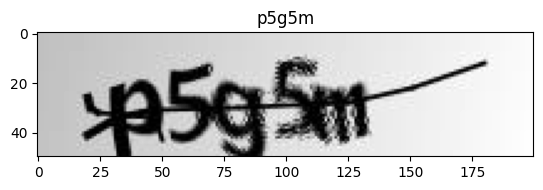

In [270]:
rand_pic = np.random.randint(0,len(y))
plt.imshow(X[rand_pic],cmap='gray')
plt.title(y_strings[rand_pic])
plt.show()

In [142]:
def translate_label(label):
    captcha_label = ''

    for i in range(5):
        idx = list(label[i]).index(1)

        captcha_label += all_characters[idx]
    return captcha_label


In [410]:
class CaptchaModel(nn.Module):
    def __init__(self, nchar):
        super(CaptchaModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(32)
        self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc_shared = nn.Linear(4800, 64)
        self.fc_outputs = nn.ModuleList([nn.Linear(64, nchar) for _ in range(5)])

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.mp1(x)
        
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.mp2(x)
        
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.bn(x)
        x = self.mp3(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        x = self.fc_shared(x)
        x = nn.functional.relu(x)
        
        outputs = [output_layer(x) for output_layer in self.fc_outputs]
        return outputs


model = CaptchaModel(nchar)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [448]:
y_tensor.size()

torch.Size([5, 1070, 36])

In [425]:
from torch.utils.data import TensorDataset

# Convert your data and labels to PyTorch tensors
X_tensor = torch.FloatTensor(X.transpose(0, 3, 1, 2))
y_tensor = torch.LongTensor(y) 

# Split the data into training and validation sets
X_train = X_tensor[:round(1070*.8)]
y_train = y_tensor[:,:round(1070*.8),:]

X_val = X_tensor[round(1070*.8):]
y_val =y_tensor[:,round(1070*.8):,:]

train_dataset = TensorDataset(X_train, y_train[0], y_train[1], y_train[2], y_train[3], y_train[4])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_val, y_val[0], y_val[1], y_val[2], y_val[3], y_val[4])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [412]:
outputs[0].size()

torch.Size([32, 36])

In [413]:
target0.size()

torch.Size([32, 36])

In [419]:
criterion(outputs[0],target0.float())

tensor(3.7248, grad_fn=<DivBackward1>)

In [462]:
# Training loop
num_epochs = 60  # Number of training epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    # Iterate over batches of the training dataset
    for inputs, target0, target1, target2, target3, target4 in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss for each output and sum them up
        targets = [target0, target1, target2, target3, target4]
        losses = [criterion(output, target.float()) for output, target in zip(outputs, targets)]
        loss = sum(losses)

        
        # Backpropagation
        loss.backward()
        
        # Update the model's parameters
        optimizer.step()
        
        running_loss += loss.item()
    
    # Print the average loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss / len(train_loader)}")

Epoch [1/60] - Loss: 0.5453723437256284
Epoch [2/60] - Loss: 0.547511687985173
Epoch [3/60] - Loss: 0.5408762682367254
Epoch [4/60] - Loss: 0.535156391285084
Epoch [5/60] - Loss: 0.5552835486553334
Epoch [6/60] - Loss: 0.5360380764360781
Epoch [7/60] - Loss: 0.5140142126215829
Epoch [8/60] - Loss: 0.49778872507589833
Epoch [9/60] - Loss: 0.5148551033602821
Epoch [10/60] - Loss: 0.4826135006215837
Epoch [11/60] - Loss: 0.39838656065640626
Epoch [12/60] - Loss: 0.3925193934528916
Epoch [13/60] - Loss: 0.40839587759088586
Epoch [14/60] - Loss: 0.4473730596127333
Epoch [15/60] - Loss: 0.37862194025958024
Epoch [16/60] - Loss: 0.37036209857022323
Epoch [17/60] - Loss: 0.3547020278595112
Epoch [18/60] - Loss: 0.31439305897112246
Epoch [19/60] - Loss: 0.33265691719673296
Epoch [20/60] - Loss: 0.36501209989741995
Epoch [21/60] - Loss: 0.3402777087909204
Epoch [22/60] - Loss: 0.3930287350107122
Epoch [23/60] - Loss: 0.3985271183428941
Epoch [24/60] - Loss: 0.3076990721402345
Epoch [25/60] - Los

In [449]:
predicted_labels = np.zeros(y_train.shape)

In [457]:
print(target0.size())
predicted.size()

torch.Size([36])


torch.Size([32])

In [474]:
correct = 0
total = 0

with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    
    for inputs, target0, target1, target2, target3, target4 in test_loader:  # Assuming test_loader is your DataLoader
        outputs = model(inputs)
        
        # Calculate accuracy for each character
        for output, target in zip(outputs, [target0, target1, target2, target3, target4]):
            predicted = output.argmax(dim=1)  # Get the index of the highest predicted value
           # predicted_labels[:, i] = predicted.numpy()
        
            for i,j in enumerate(predicted):
                
                if target[i][j] == 1:
                    correct += 1
                total += 1

# Calculate overall accuracy
accuracy = correct / total
print(f"Accuracy: {accuracy:.2%}")



Accuracy: 51.31%


In [471]:
target.size()

torch.Size([32, 36])

In [239]:
class CaptchaModel(nn.Module):
    def __init__(self, imgshape, nchar):
        super(CaptchaModel, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # 50*200
        self.mp1 = nn.MaxPool2d(kernel_size=2, padding=0)  # 25*100
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.mp2 = nn.MaxPool2d(kernel_size=2, padding=0)  # 13*50
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(32)  # to improve the stability of model
        self.mp3 = nn.MaxPool2d(kernel_size=2, padding=0)  # 7*25

        self.fc1 = nn.Linear(4800, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64,  5 *36)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.mp1(x)
        x = F.relu(self.conv2(x))
        x = self.mp2(x)
        x = F.relu(self.conv3(x))
        x = self.bn(x)
        x = self.mp3(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))

        return x

In [ ]:
# Assuming imgshape is (1, 50, 200) and nchar is the number of characters in your captcha
imgshape = (1, 50, 200)
nchar = 5
model = CaptchaModel(imgshape, nchar)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-3)


In [ ]:
# Training 
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    # Loop through the entire dataset
    for i in range(len(X)):
        inputs = X[i]
        labels = y[i]
        
        inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(1).unsqueeze(0)  # Add batch and channel dimensions
        labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
        
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        
        # Reshape the outputs and labels
        outputs = outputs.view(1, 5, 36)
        labels = labels.view(1, 5, 36)
        
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()
        
        if (i + 1) % 320 == 0:  # Print every 320 iterations
            print(f'Epoch [{epoch+1}/{num_epochs}], Iteration [{i+1}/{len(X)}], Loss: {running_loss / (i+1):.4f}')


